# DOMAIN: Entertainment
## • CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene. The data labelling is already done. Since there higher time complexity is involved in the

### • DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.
### • PROJECT OBJECTIVE: To build a face detection system.

## Steps and tasks: [ Total Score: 20 Marks]

In [3]:
#PARTA.1 Import and Understand the data [7 Marks]
#PARTA.1.A. Import and read ‘images.npy’. [1 Marks]

# Import all the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf 
import os

import warnings
warnings.filterwarnings('ignore')

images = np.load('images.npy', allow_pickle=True)

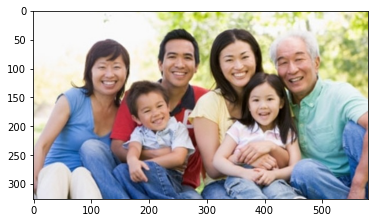

In [17]:
plt.imshow(images[4][0])

In [27]:
#PARTA.1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks]
# Imp Note: Replace all the pixels within masked area with 1.
# Hint: X will comprise of array of image whereas Y will comprise of coordinates of the 
# mask(human face). Observe: data[0], data[0][0], data[0][1].
import cv2
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet import preprocess_input
tf.__version__

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
#Feature
X = np.zeros((int(images.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#Labels
Y  = np.zeros((int(images.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

# Unify shape of all images
for index in range(images.shape[0]):
    image = images[index][0]
    img = cv2.resize(image,dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    
    #if there is a gray scale image convert it to color
    if(len(img.shape)<3):
        img=cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    X[index] = preprocess_input(np.array(img[:,:,:3], dtype=np.float32))
    for i in images[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        #Replace all the pixels within masked area with 1.
        Y[index][y1:y2, x1:x2] = 1

In [30]:
#PARTA.1.C. Split the data into train and test[400:9]. [1 Marks]
# Since a specific number was asked as test train aplit 
X_train = X[:399]
y_train = Y[:399]

X_test = X[400:409]
y_test = Y[400:409]

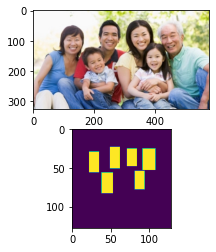

In [31]:
#PARTA.1.D. Select random image from the train data and display original image and masked image. [2 Marks]

index_to_display=4
fig,ax=plt.subplots(2)
ax[0].imshow(images[index_to_display][0])
ax[1].imshow(Y[index_to_display])

In [29]:
# All six face masks identified

### PARTA.2. Model building [11 Marks]

In [48]:
#PARTA.2.A. Design a face mask detection model. [4 Marks]
# Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.
# Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture

import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,BatchNormalization,Dropout,SeparableConv2D,SpatialDropout2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block2 = model.get_layer("conv1_relu").output
    block3 = model.get_layer("conv_pw_2_relu").output
    block4 = model.get_layer("conv_pw_5_relu").output
    block5 = model.get_layer("conv_pw_11_relu").output
    block6 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [49]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']         

                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 16, 16, 256)  0           ['conv_pw_5_bn[0][0]']           
                                                                                                  
 conv_pad_6 (ZeroPadding2D)     (None, 17, 17, 256)  0           ['conv_pw_5_relu[0][0]']         
                                                                                                  
 conv_dw_6 (DepthwiseConv2D)    (None, 8, 8, 256)    2304        ['conv_pad_6[0][0]']             
                                                                                                  
 conv_dw_6_bn (BatchNormalizati  (None, 8, 8, 256)   1024        ['conv_dw_6[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_dw_6

                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 8, 8, 512)   2048        ['conv_pw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_pw_11_relu (ReLU)         (None, 8, 8, 512)    0           ['conv_pw_11_bn[0][0]']          
                                                                                                  
 conv_pad_12 (ZeroPadding2D)    (None, 9, 9, 512)    0           ['conv_pw_11_relu[0][0]']        
                                                                                                  
 conv_dw_12 (DepthwiseConv2D)   (None, 4, 4, 512)    4608        ['conv_pad_12[0][0]']            
                                                                                                  
 conv_dw_1

In [50]:
#PARTA.2.B. Design your own Dice Coefficient and Loss function. [2 Marks]
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [1]:
#PARTA.2.C. Train and tune the model as required. [3 Marks]
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1)

2023-02-12 11:29:22.904743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 11:29:29.203339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, verbose=1, 
          steps_per_epoch=len(X_train),validation_steps=len(X_test),
          callbacks=[stop,checkpoint,reduce_lr])


In [76]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print("model, accuracy: {:5.2f}%".format(100 * test_acc))

1/1 - 1s - loss: 0.7048 - dice_coefficient: 0.6101 - 568ms/epoch - 568ms/step
model, accuracy: 61.01%


In [61]:
### Model Accuracy is almost 61%

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


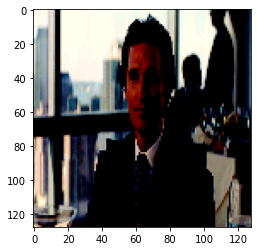

In [77]:
#PARTA.2.3. Test the model predictions on the test image: ‘image with index 3 in the test data’ 
#and visualise the predicted masks on the faces in the image. [2 Marks]
test_id = 3
plt.imshow(X_test[test_id])

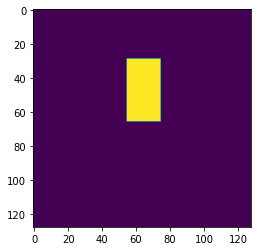

In [78]:
plt.imshow(y_test[test_id])

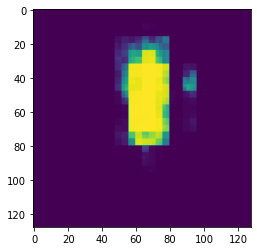

In [79]:
predicted = model.predict(np.reshape(X_test[test_id], [1, IMAGE_HEIGHT, IMAGE_WIDTH, 3]))
plt.imshow(predicted[0])

In [80]:
# Predicted mask is very close. However additonal face in the background is also identified. 

## Part B - 10 Marks
### • DOMAIN: Entertainment
### • CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
### The data labelling is already done. Since there higher time complexity is involved in the 

### DATA DESCRIPTION: The dataset comprises of face images.
### • PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.
### Steps and tasks: [ Total Score: 10 Marks]
1. Read/import images from folder ‘training_images’. [2 Marks]
2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks]
#### Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.
3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]
4. Save the output Dataframe in .csv format. [2 Marks]

In [121]:
# Part B.1 Read/import images from folder ‘training_images’. [2 Marks]
import glob
img_dir = "./training_images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g') # '*' is used to extract all files in the directory
files = glob.glob(data_path)
data = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)
dir_list = next(os.walk(img_dir))[2]

In [122]:
len(data)

1091

In [134]:
# 2. Write a loop which will iterate through all the images in the ‘training_images’ 
# folder and detect the faces present on all the images. [3 Marks]
# Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is 
#available open source.
import cv2
x_cord=[]
y_cord=[]
height=[]
width=[]
face_detected=[]
image_name=[]

for i in range (len(dir_list)):
    # Create a cascade classfier object
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                       'haarcascade_frontalface_default.xml')
    
    data_path = os.path.join(img_dir,dir_list[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)

    j=0 

    # Find coordinates of the face
    for x,y,w,h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
        j=j+1
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))
    
    length=len(faces)
    if length==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0
        
    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=dir_list[i]
        
    
    x_cord.append(a)
    y_cord.append(b)
    width.append(c)
    height.append(d)
    face_detected.append(j)
    image_name.append(name)

In [135]:
# PARTB.3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]
import pandas as pd

df_upd = pd.DataFrame(x_cord, columns = ['x'])
df_upd['y']=y_cord
df_upd['w']=width
df_upd['h']=height
df_upd['Total_Faces']=face_detected
df_upd['Image_Name']=image_name

df_upd.head()

,x,y,w,h,Total_Faces,Image_Name
0,94,144,390,390,1,real_00251.jpg
1,65,87,459,459,1,real_00537.jpg
2,115,149,386,386,1,real_00523.jpg
3,82,137,395,395,1,real_00245.jpg
4,142,204,376,376,1,real_00279.jpg


In [136]:
#PARTB.4. Save the output Dataframe in .csv format. [2 Marks]
df_upd.to_csv("ImageDataset.csv")

# Part C - 30 Marks
## • DOMAIN: Face Recognition
## • CONTEXT: Company X intends to build a face identification model to recognise human faces.
### DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
### PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:

In [224]:
#Part C.1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks]
from zipfile import ZipFile

with ZipFile(file='PINS.zip',mode='r') as zf:
  zf.extractall()

In [225]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

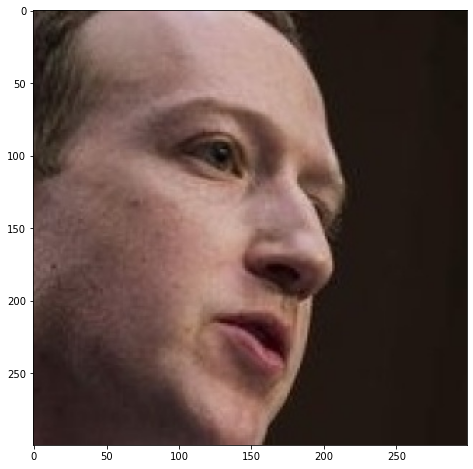

In [226]:
import matplotlib.pyplot as plt
img=load_image(metadata[0].image_path())
plt.figure(figsize=(8,8))
plt.imshow(img)

In [227]:
#Part C.2. Write function to create metadata of the image. [4 Marks] 
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    


In [228]:
#PartC.3. Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]

In [229]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

In [230]:
metadata.shape

(10770,)

In [231]:
metadata

array([PINS/pins_mark zuckerberg/mark zuckerberg1.jpg,
       PINS/pins_mark zuckerberg/mark zuckerberg50.jpg,
       PINS/pins_mark zuckerberg/mark zuckerberg44.jpg, ...,
       PINS/pins_tati gabrielle/tati gabrielle21.jpg,
       PINS/pins_tati gabrielle/tati gabrielle20.jpg,
       PINS/pins_tati gabrielle/tati gabrielle34.jpg], dtype=object)

In [232]:
#PartC.4. Generate Embeddings vectors on the each face in the dataset. [4 Marks]

#Predefined model for VGG face
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [233]:
# Load the model defined above
# Then load the given weight file named "vgg_face_weights.h5"
model = vgg_face()
model.load_weights(filepath='./vgg_face_weights.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_26 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_35 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_27 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                      

In [234]:
# Get vgg_face_descriptor
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [235]:
def get_embedding(img_path):
    img = load_image(img_path)
    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    return vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    

In [238]:
#Generate embeddings for all images
from tqdm import tqdm
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in tqdm(enumerate(metadata)):
  embeddings[i]=get_embedding(metadata[i].image_path())

10770it [55:27,  3.24it/s]


In [240]:
#Saving the embeddings into npy file so can re-use it without the need of running the predict func
np.save(file='./embeddings.npy', arr=embeddings, allow_pickle=True)

In [241]:
#PartC.5. Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]
# Consider distance metric as "Squared L2 distance"
# Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [242]:
# Loading the embeddings that are saved
embeddings=np.load(file='./embeddings.npy',allow_pickle=True)
embeddings.shape

(10770, 2622)

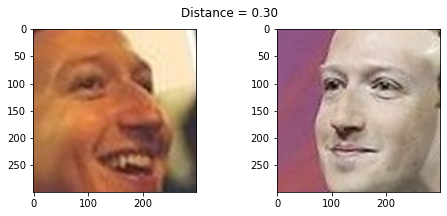

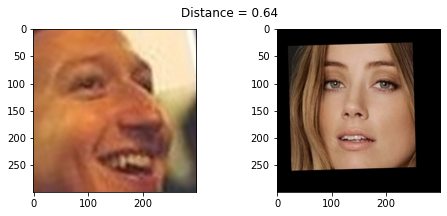

In [243]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 182)

In [244]:
#Create X_train, X_test and y_train, y_test
#Use train_idx to seperate out training features and labels
#Use test_idx to seperate out testing features and labels

train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# train and test split
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [245]:
#Encode the Labels (3 marks)
#Encode the targets
#Use LabelEncoder

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train_enc=label_encoder.transform(y_train)
y_test_enc=label_encoder.transform(y_test)

print("Number of target class types is -> ", len(label_encoder.classes_))
print("\n Target classes are\n", label_encoder.classes_)

Number of target class types is ->  100

 Target classes are
 ['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman '
 'pins_Neil Patrick Harris' 'pin

In [246]:
# Standarize features
# Scale the features using StandardScaler
from sklearn.preprocessing import StandardScaler

std_scale=StandardScaler()
std_scale= std_scale.fit(X_train)
X_train_scaled= std_scale.transform(X_train)
X_test_scaled= std_scale.transform(X_test)

In [247]:
# PartC.6. Use PCA for dimensionality reduction. [2 Marks]
# Reduce feature dimensions using Principal Component Analysis
# Set the parameter n_components=128

from sklearn.decomposition import PCA

pca=PCA(n_components=128)
pca=pca.fit(X_train_scaled)
#X_pca_scaled=pca.transform(X_scaled)
print("Explained Variance ratios of each PCA: ",pca.explained_variance_ratio_)
print("Cummulative sum of Variance ratios for PCAs: ",np.cumsum(pca.explained_variance_ratio_))

Explained Variance ratios of each PCA:  [0.13564193 0.05393976 0.03974748 0.03649469 0.03420402 0.03114433
 0.02569042 0.02360062 0.0209847  0.01928305 0.01827528 0.01710848
 0.01661905 0.01556699 0.01415749 0.01373387 0.01309154 0.01232567
 0.01162604 0.01133266 0.01099172 0.01052213 0.00965396 0.00944639
 0.00919317 0.00885025 0.0083736  0.00762812 0.00758773 0.00738743
 0.00703431 0.00661821 0.00637278 0.00618635 0.00570241 0.00539184
 0.00524791 0.00518226 0.00504051 0.0048122  0.00439281 0.00434793
 0.003967   0.00393871 0.00369405 0.00354951 0.00343778 0.00335852
 0.00326484 0.0031629  0.00312741 0.00309207 0.00288942 0.00282947
 0.00280545 0.00272013 0.00269985 0.00261708 0.00252478 0.00248289
 0.00239053 0.00232533 0.00225274 0.00214658 0.00210608 0.00205677
 0.00202614 0.00195944 0.00188118 0.00183555 0.00182712 0.00180026
 0.00176191 0.00173198 0.00169787 0.00165139 0.00164826 0.00160766
 0.00157023 0.00153808 0.00153251 0.00149329 0.00146165 0.00143424
 0.00142204 0.00138275

In [248]:
# Obtaining PCA attributes for train and test set
X_train_pca_scaled=pca.transform(X_train_scaled)
X_test_pca_scaled=pca.transform(X_test_scaled)

In [249]:
# PartC.7. Build an SVM classifier in order to map each image to its right person. [4 Marks]
# Use SVM Classifier to predict the person in the given image
# Fit the classifier and print the score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc_model=SVC()
svc_model=svc_model.fit(X_train_pca_scaled,y_train_enc)
y_train_pred=svc_model.predict(X_train_pca_scaled)
y_test_pred=svc_model.predict(X_test_pca_scaled)
print("Training data accuracy: ",accuracy_score(y_train_enc,y_train_pred))
print("Testing data accuracy: ",accuracy_score(y_test_enc,y_test_pred))

Training data accuracy:  0.9963438838399665
Testing data accuracy:  0.9632414369256475


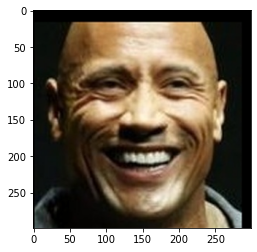

In [250]:
#PartC.8 Import and display the the test images. [2 Marks]
plt.imshow(load_image('./DwayneJohnson4.jpg'))


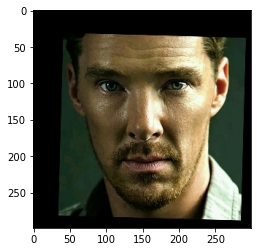

In [251]:
plt.imshow(load_image('./BenedictCumberbatch9.jpg'))

In [270]:

#PartC.9 Use the trained SVM model to predict the face on both test images. [4 Marks]


def predict_person(test_input_image, debug=False):
    # Load the image
    raw_image = load_image(test_input_image)

    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    raw_image_normalized = (raw_image / 255.).astype(np.float32)
    raw_image_normalized_resized = cv2.resize(raw_image_normalized, dsize = (224,224))
    if (debug):
        print("Normalized and resized image shape: ", raw_image_normalized_resized.shape)

    # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(raw_image_normalized_resized, axis=0))[0]
    if (debug):
        print("Embedding vector shape", embedding_vector.shape)

    embedding_vector = np.expand_dims(embedding_vector, axis=0)
    if (debug):
        print("Embedding vector shape", embedding_vector.shape)

    # Standarize features
    embedding_vector_std = std_scale.transform(embedding_vector)
    if (debug):
        print('Embedding_vector_std shape : ({0},{1})'.format(embedding_vector_std.shape[0], embedding_vector_std.shape[1]))

    # Reduce the input feature dimension from size 2622 to 128 !
    embedding_vector_pca = pca.transform(embedding_vector_std)

    # Run SVC classifier to predict the output class
    predicted_class_vector = svc_model.predict(embedding_vector_pca)

    # Lets get the class name from predicted class vector
    predicted_class_name = label_encoder.inverse_transform(predicted_class_vector)

    plt.imshow(raw_image_normalized_resized)
    plt.title(f'Identified person as -> {predicted_class_name}');

Normalized and resized image shape:  (224, 224, 3)
Embedding vector shape (2622,)
Embedding vector shape (1, 2622)
Embedding_vector_std shape : (1,2622)


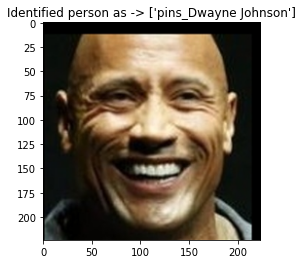

In [271]:
#PartC.8 Import and display the the test images. [2 Marks]

predict_person('./DwayneJohnson4.jpg', True)

Normalized and resized image shape:  (224, 224, 3)
Embedding vector shape (2622,)
Embedding vector shape (1, 2622)
Embedding_vector_std shape : (1,2622)


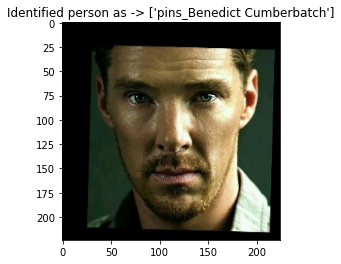

In [272]:
predict_person('./BenedictCumberbatch9.jpg', True)

In [ ]:
#Identification was Correct 